In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [17]:
data = pd.read_csv("../data/MSFT.csv")
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index("Date")
# data = data.diff().dropna()

In [18]:
# last_date = data.index[-1]

# # Create a 2-week offset
# offset = timedelta(weeks=2)

# start = '2009-05-08'
# end = last_date-offset

# dataframe = data.copy()
# dataframe = dataframe.loc[start:end, :]
# dataframe

In [19]:
def load_data(start, end=None):
    last_date = data.index[-1]
    offset = datetime.timedelta(weeks=2)

    dataframe = data.copy()
    if not end:
        end = last_date-offset

    dataframe = dataframe.loc[start:end, :]
    return dataframe.rename(columns = {'Closing_Price': 'Close'})

In [20]:
train_set = load_data('2009-05-08')

In [21]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train_set['Close'].values.reshape(-1,1))

# how many days do i want to base my predictions on ?
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [22]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

In [23]:
from keras.callbacks import EarlyStopping
from keras.metrics import RootMeanSquaredError

model = LSTM_model()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [24]:
checkpointer = ModelCheckpoint(filepath = '../model/weights_best.hdf5', 
                               verbose = 1, 
                               save_best_only = True)


history = model.fit(x_train,
          y_train, 
          validation_split=0.3,
          epochs=25, 
          batch_size = 32,
          callbacks = [checkpointer])

Epoch 1/25
85/85 [==============================] - ETA: 0s - loss: 0.0022
Epoch 1: val_loss improved from inf to 0.00131, saving model to ../model\weights_best.hdf5
85/85 [==============================] - 9s 49ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 2/25
85/85 [==============================] - ETA: 0s - loss: 3.5596e-04
Epoch 2: val_loss improved from 0.00131 to 0.00127, saving model to ../model\weights_best.hdf5
85/85 [==============================] - 3s 33ms/step - loss: 3.5596e-04 - val_loss: 0.0013
Epoch 3/25
85/85 [==============================] - ETA: 0s - loss: 3.7944e-04
Epoch 3: val_loss did not improve from 0.00127
85/85 [==============================] - 3s 31ms/step - loss: 3.7944e-04 - val_loss: 0.0018
Epoch 4/25
85/85 [==============================] - ETA: 0s - loss: 3.1648e-04
Epoch 4: val_loss did not improve from 0.00127
85/85 [==============================] - 3s 32ms/step - loss: 3.1648e-04 - val_loss: 0.0015
Epoch 5/25
85/85 [==========================

In [25]:
last_date = data.index[-1]
offset = datetime.timedelta(weeks=2)

test_data = load_data(start = last_date - offset,
                      end = last_date)

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

x_test = [
    model_inputs[x - prediction_days : x, 0]
    for x in range(prediction_days, len(model_inputs))
]
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

1/1 [==============================] - 1s 1s/step


In [26]:
predicted_prices

array([[228.38374],
       [229.74237],
       [231.45415],
       [232.78275],
       [233.17729],
       [232.69734],
       [231.62863],
       [230.34798],
       [229.3925 ],
       [229.07668]], dtype=float32)

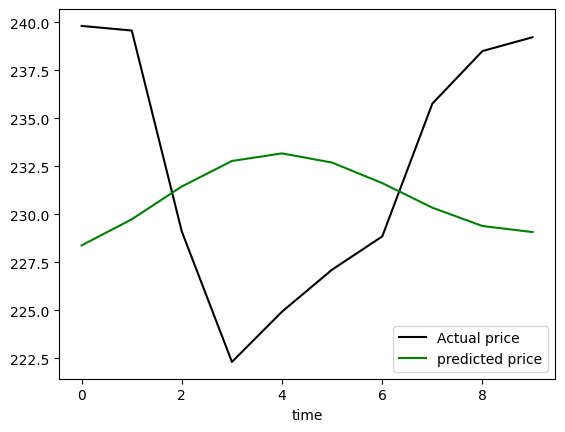

In [27]:
plt.plot(actual_prices, color='black', label="Actual price")
plt.plot(predicted_prices, color= 'green', label="predicted price")
# plt.title(f"{COMPANY} share price")
plt.xlabel("time")
# plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()